  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

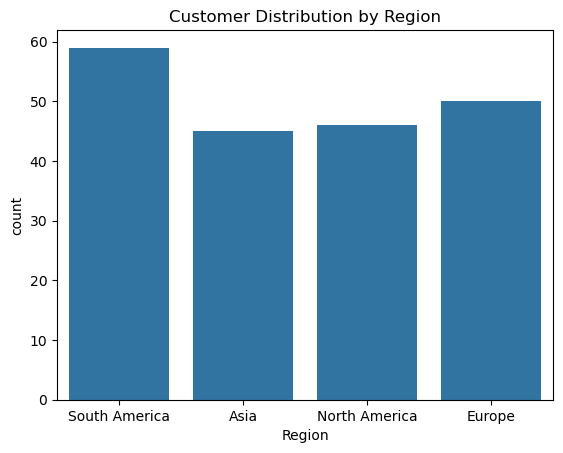

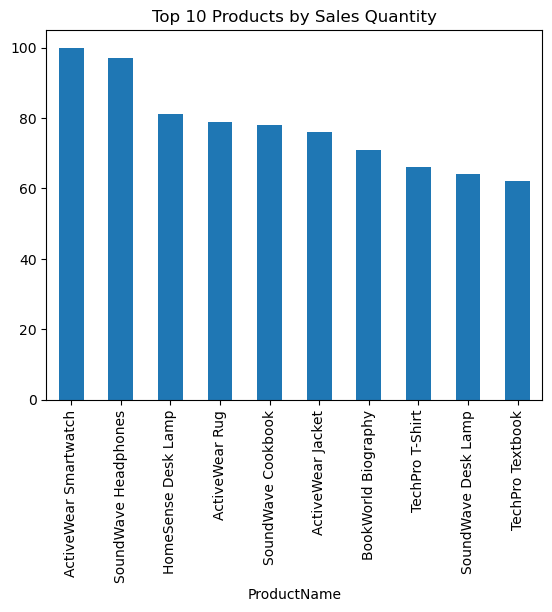

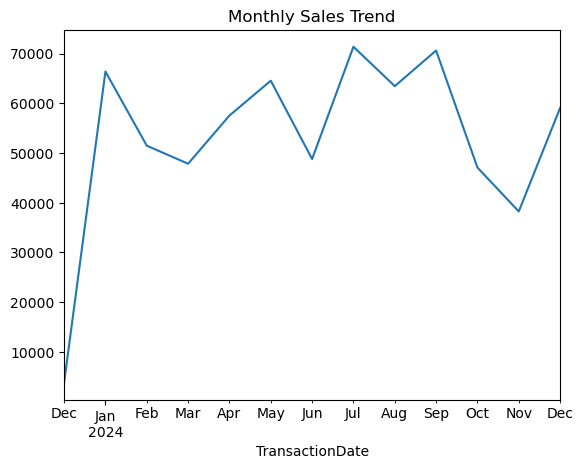

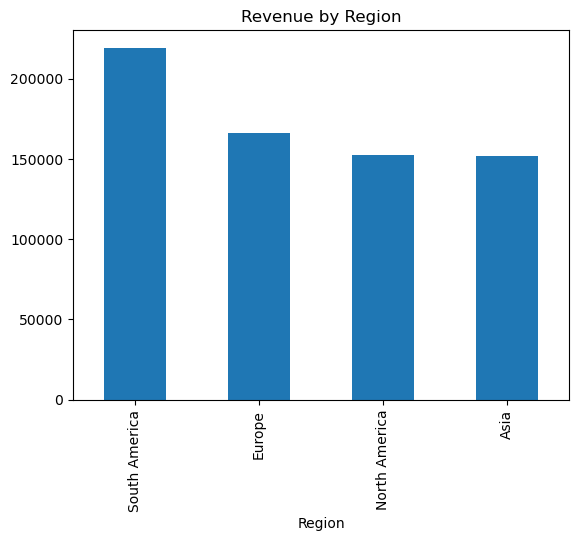

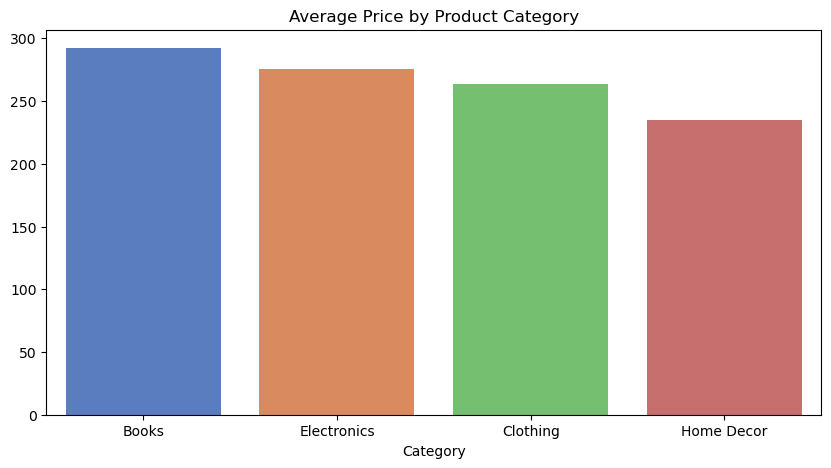

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Preview data
print(customers.head())
print(products.head())
print(transactions.head())

# Merge datasets for analysis
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

# Clean and inspect
print(merged_data.info())
print(merged_data.describe())

# Handle missing values (if any)
merged_data = merged_data.dropna()

# Analyze Customers
print(customers['Region'].value_counts())
sns.countplot(data=customers, x='Region')
plt.title("Customer Distribution by Region")
plt.show()

# Analyze Products
top_products = merged_data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', title='Top 10 Products by Sales Quantity')
plt.show()

# Sales Analysis
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
sales_trend = merged_data.groupby(merged_data['TransactionDate'].dt.to_period('M'))['TotalValue'].sum()
sales_trend.plot(kind='line', title="Monthly Sales Trend")
plt.show()

# Revenue by Region
revenue_by_region = merged_data.groupby('Region')['TotalValue'].sum().sort_values(ascending=False)
revenue_by_region.plot(kind='bar', title="Revenue by Region")
plt.show()

#Average Price Category
avg_price_category = products.groupby('Category')['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_price_category.index, y=avg_price_category.values, palette="muted", hue=avg_price_category.index, dodge=False, legend=False)
plt.title("Average Price by Product Category")
plt.xlabel("Category")
plt.show()


In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

# -------------------- Lookalike Model -------------------- #

total_spending = merged_data.groupby('CustomerID')['TotalValue'].sum().rename('TotalSpending')


avg_purchase_value = merged_data.groupby('CustomerID')['TotalValue'].mean().rename('AvgPurchaseValue')

unique_products = merged_data.groupby('CustomerID')['ProductID'].nunique().rename('UniqueProducts')

transaction_count = merged_data.groupby('CustomerID')['TransactionID'].nunique().rename('TransactionCount')

customer_features = pd.DataFrame({
    'TotalSpending': total_spending,
    'AvgPurchaseValue': avg_purchase_value,
    'UniqueProducts': unique_products,
    'TransactionCount': transaction_count
}).fillna(0)

scaler = MinMaxScaler()
customer_features_scaled = pd.DataFrame(scaler.fit_transform(customer_features), 
                                        index=customer_features.index, 
                                        columns=customer_features.columns)

similarity_matrix = cosine_similarity(customer_features_scaled)
similarity_df = pd.DataFrame(similarity_matrix, 
                             index=customer_features_scaled.index, 
                             columns=customer_features_scaled.index)

# Recommend Top 3 Lookalike Customers
lookalike_results = {}
for customer_id in similarity_df.index[:20]:  # First 20 customers (C0001 to C0020)
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]  # Exclude self (top match)
    lookalike_results[customer_id] = [(sim_id, round(score, 4)) for sim_id, score in similar_customers.items()]

lookalike_csv = []
for cust_id, lookalikes in lookalike_results.items():
    for similar_cust_id, score in lookalikes:
        lookalike_csv.append({'CustomerID': cust_id, 'SimilarCustomerID': similar_cust_id, 'SimilarityScore': score})

lookalike_df = pd.DataFrame(lookalike_csv)
lookalike_df.to_csv("Lookalike.csv", index=False)

print("Lookalike Model complete. Results saved to Lookalike.csv.")

df = pd.read_csv("Lookalike.csv")
print(df)

Lookalike Model complete. Results saved to Lookalike.csv.
   CustomerID SimilarCustomerID  SimilarityScore
0       C0001             C0137           1.0000
1       C0001             C0152           1.0000
2       C0001             C0056           0.9996
3       C0002             C0029           0.9997
4       C0002             C0199           0.9994
5       C0002             C0031           0.9991
6       C0003             C0178           1.0000
7       C0003             C0035           0.9996
8       C0003             C0133           0.9995
9       C0004             C0021           1.0000
10      C0004             C0124           0.9994
11      C0004             C0090           0.9992
12      C0005             C0073           1.0000
13      C0005             C0159           1.0000
14      C0005             C0112           0.9998
15      C0006             C0079           1.0000
16      C0006             C0117           0.9998
17      C0006             C0158           0.9983
18      C00

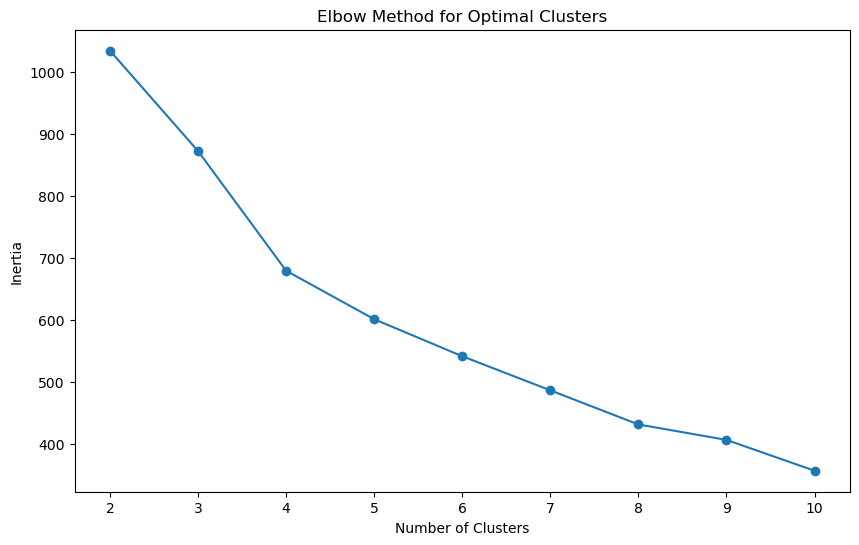

KMeans Davies-Bouldin Index: 1.2241425724411819


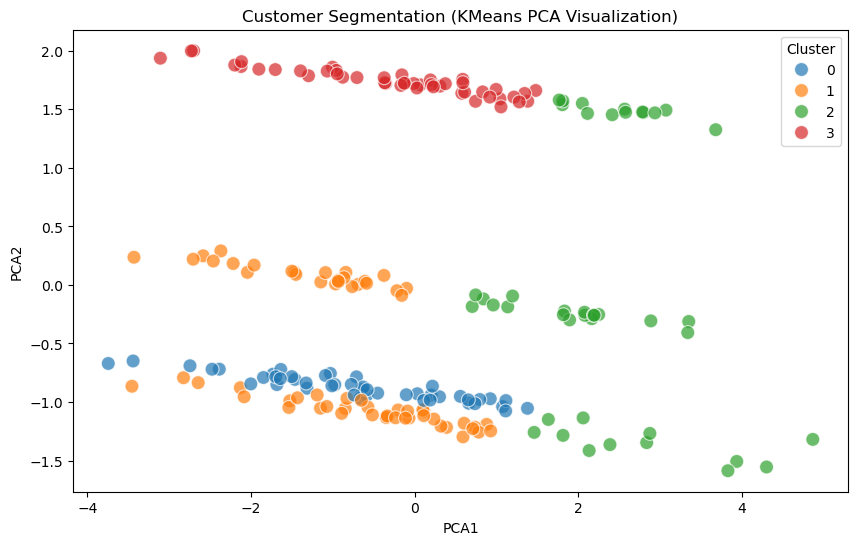

DBSCAN Davies-Bouldin Index: 0.8912230470947684


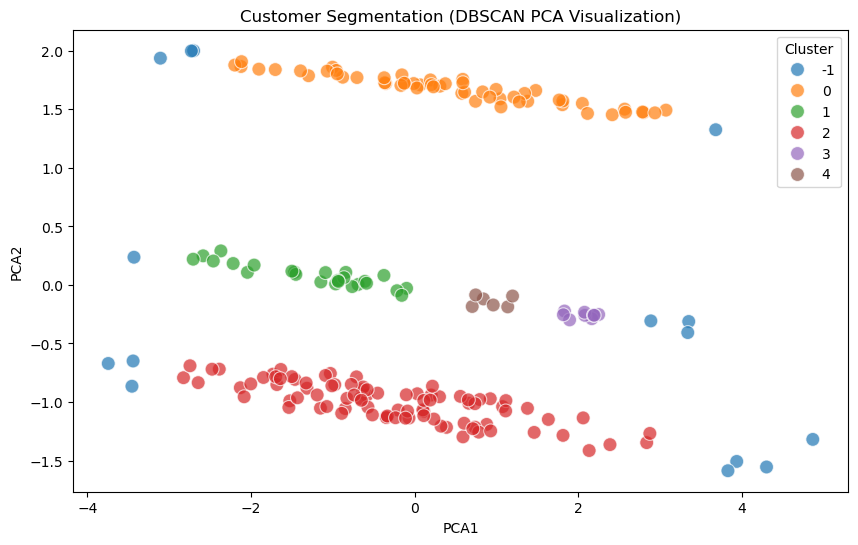

Clustering Results:
KMeans - Number of clusters formed: 4, Davies-Bouldin Index: 1.2241425724411819
DBSCAN - Number of clusters formed: 5, Davies-Bouldin Index: 0.8912230470947684


,CustomerID,TotalValue,TransactionID,Quantity,Price_x,CustomerName,SignupDate,Region_Europe,Region_North America,Region_South America,KMeans_Cluster,PCA1_KMeans,PCA2_KMeans,DBSCAN_Cluster
0,C0001,3354.52,5,12,278.334000,Lawrence Carroll,2022-07-10,False,False,True,3,0.068699,1.709045,0
1,C0002,1862.74,4,10,208.920000,Elizabeth Lutz,2022-02-13,False,False,False,1,-1.146758,0.025338,1
2,C0003,2725.38,4,14,195.707500,Michael Rivera,2024-03-07,False,False,True,3,-0.354764,1.721877,0
3,C0004,5354.88,8,23,240.636250,Kathleen Rodriguez,2022-10-09,False,False,True,2,2.414133,1.454060,0
4,C0005,2034.24,3,7,291.603333,Laura Weber,2022-08-15,False,False,False,1,-1.467719,0.109121,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,C0196,4982.88,4,12,416.992500,Laura Watts,2022-06-07,True,False,False,0,0.216915,-0.865008,2
195,C0197,1928.65,3,9,227.056667,Christina Harvey,2023-03-21,True,False,False,0,-1.642205,-0.800931,2
196,C0198,931.83,2,3,239.705000,Rebecca Ray,2022-02-27,True,False,False,0,-2.745909,-0.690666,2
197,C0199,1979.28,4,9,250.610000,Andrea Jenkins,2022-12-03,True,False,False,0,-1.326769,-0.837907,2


In [29]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

merged_data.columns
customer_summary = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spend
    "TransactionID": "count",  # Number of transactions
    "Quantity": "sum",  # Total quantity purchased
    "Price_x": "mean"  # Average price per transaction
}).reset_index()

customer_summary = customer_summary.merge(customers, on="CustomerID")

# Convert Region to numeric using one-hot encoding
customer_summary = pd.get_dummies(customer_summary, columns=["Region"], drop_first=True)

# Select features for clustering
features = ["TotalValue", "TransactionID", "Quantity", "Price_x"] + [col for col in customer_summary.columns if "Region_" in col]
data_for_clustering = customer_summary[features]


# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

# Option 1: KMeans Clustering
# Determine the optimal number of clusters using the elbow method
inertia = []
range_clusters = range(2, 11)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inertia, marker="o")
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Choose the optimal number of clusters (e.g., based on the elbow plot)
optimal_clusters = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_summary["KMeans_Cluster"] = kmeans.fit_predict(data_scaled)

# Calculate Davies-Bouldin Index for KMeans
db_index_kmeans = davies_bouldin_score(data_scaled, customer_summary["KMeans_Cluster"])
print(f"KMeans Davies-Bouldin Index: {db_index_kmeans}")

# Visualize KMeans clusters using 2D PCA
pca = PCA(n_components=2)
pca_data_kmeans = pca.fit_transform(data_scaled)
customer_summary["PCA1_KMeans"] = pca_data_kmeans[:, 0]
customer_summary["PCA2_KMeans"] = pca_data_kmeans[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1_KMeans", y="PCA2_KMeans", hue="KMeans_Cluster", data=customer_summary, palette="tab10", s=100, alpha=0.7
)
plt.title("Customer Segmentation (KMeans PCA Visualization)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

# Option 2: DBSCAN Clustering
# Reduce dimensionality with PCA (optional but recommended for high dimensions)
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_scaled)

# Apply DBSCAN (tune eps and min_samples)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Tune these parameters
customer_summary["DBSCAN_Cluster"] = dbscan.fit_predict(data_reduced)

# Filter noise points (-1 represents noise in DBSCAN)
valid_clusters = customer_summary[customer_summary["DBSCAN_Cluster"] != -1]

# Calculate Davies-Bouldin Index for DBSCAN (if valid clusters exist)
if len(valid_clusters["DBSCAN_Cluster"].unique()) > 1:
    db_index_dbscan = davies_bouldin_score(data_reduced[valid_clusters.index], valid_clusters["DBSCAN_Cluster"])
    print(f"DBSCAN Davies-Bouldin Index: {db_index_dbscan}")
else:
    print("DBSCAN did not identify sufficient clusters for DB Index evaluation.")

# Visualize DBSCAN clusters using PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_reduced[:, 0],
    y=data_reduced[:, 1],
    hue=customer_summary["DBSCAN_Cluster"],
    palette="tab10",
    s=100,
    alpha=0.7
)
plt.title("Customer Segmentation (DBSCAN PCA Visualization)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

# Save clustering results
customer_summary.to_csv("Customer_Segmentation_Results.csv", index=False)
# Report
print("Clustering Results:")
print(f"KMeans - Number of clusters formed: {optimal_clusters}, Davies-Bouldin Index: {db_index_kmeans}")
if 'db_index_dbscan' in locals():
    print(f"DBSCAN - Number of clusters formed: {len(valid_clusters['DBSCAN_Cluster'].unique())}, Davies-Bouldin Index: {db_index_dbscan}")

customer_summary